In [1]:
import torch
from matplotlib import pyplot as plt
import yaml

from models.autoencoder import Autoencoder
from data.era5 import ERA5Dataset, gen_bgen

from metrics.metrics import WeightedRMSE

In [2]:
with open("configs/autoencoder/kl-f8.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

device = "cpu"

model : Autoencoder = Autoencoder.load_from_checkpoint(
    "checkpoints/vae-kl-f8-rmse-disc-2-step=5000-z500=93.ckpt", config=config, strict=False).to(device)

model.eval()

bgen = gen_bgen(train=False)
dataset = ERA5Dataset(bgen)

sample = dataset[0].unsqueeze(0)

c:\Users\hendr\Desktop\3d-vae\venv\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1, which is newer than your current Lightning version: v2.5.0.post0


In [3]:
with torch.no_grad():
    sample = sample.to(model.device)

    rec, posterior = model.forward(sample)

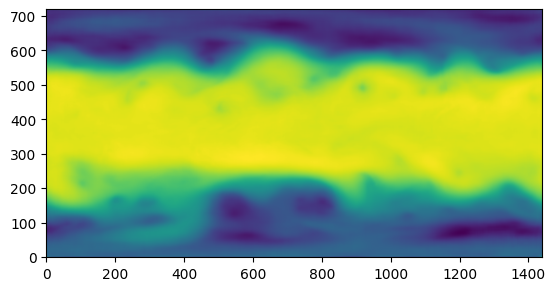

In [4]:
geo = rec.cpu().squeeze().numpy()

plt.imshow(geo[50].T, origin="lower")

(1, 64, 180, 90)


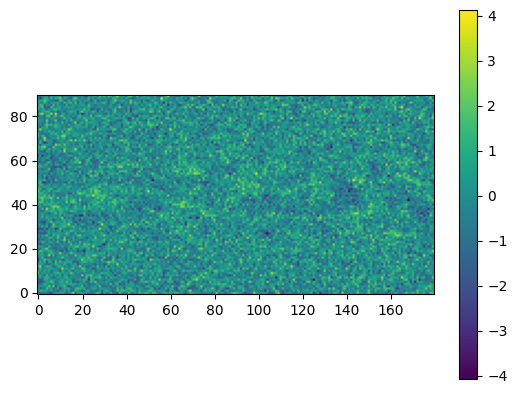

In [29]:
latent = posterior.sample().cpu().numpy()

print(latent.shape)

plt.figure()
plt.imshow(latent[0][31].T, origin="lower")
plt.colorbar()
plt.show()

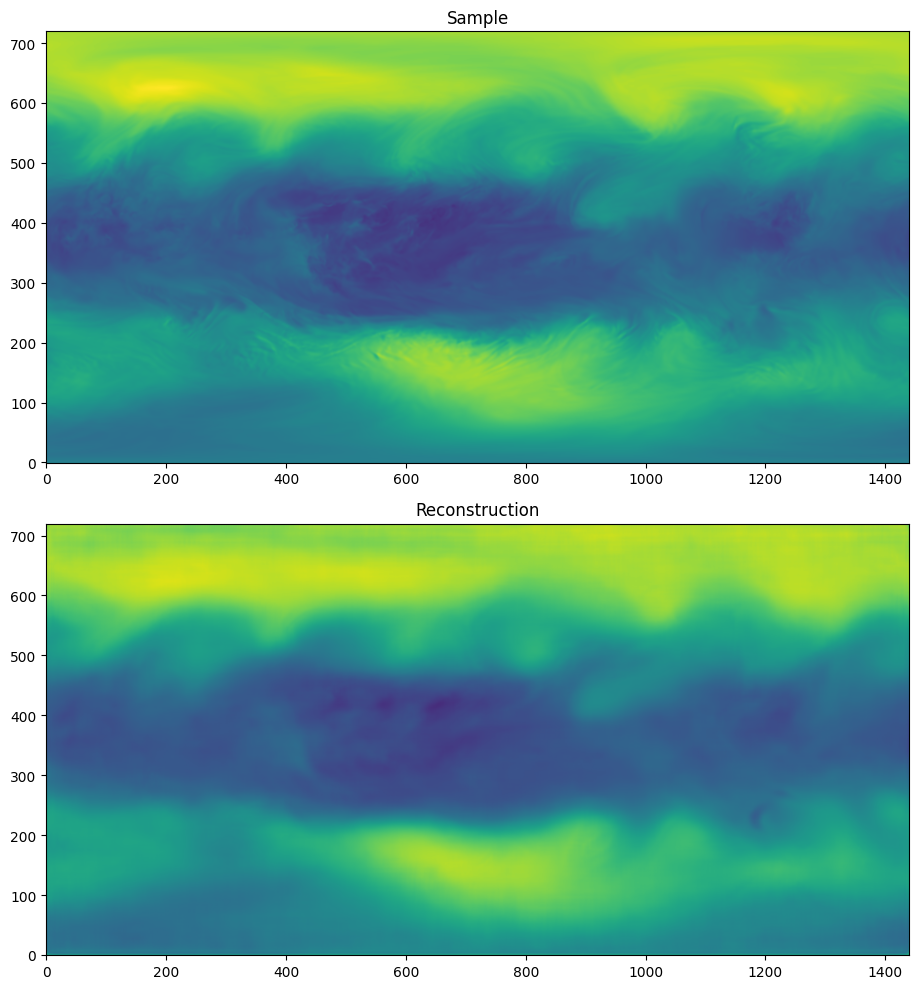

In [28]:
geo_sample = sample.cpu()
geo_rec = rec.cpu()

# geo_sample = torch.nn.functional.interpolate(geo_sample, (240, 120))
# geo_rec = torch.nn.functional.interpolate(geo_rec, (240, 120))

geo_sample = geo_sample.squeeze().numpy()[5]
geo_rec = geo_rec.squeeze().numpy()[5]

# plt.figure()
# plt.imshow(geo_sample.T, origin="lower", vmin=-2.5, vmax=2)
# plt.figure()
# plt.imshow(geo_rec.T, origin="lower", vmin=-2.5, vmax=2)

# make 1x2 grid
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].imshow(geo_sample.T, origin="lower", vmin=-2.5, vmax=2)
axs[0].set_title("Sample")
axs[1].imshow(geo_rec.T, origin="lower", vmin=-2.5, vmax=2)
axs[1].set_title("Reconstruction")

plt.tight_layout()

plt.show()

In [19]:
geo_mean = 276.707305
geo_std = 20.9942404

geo_sample_denorm = (geo_sample * geo_std) + geo_mean
geo_rec_denorm = (geo_rec * geo_std) + geo_mean

In [20]:
import numpy as np

np.min(geo_sample_denorm)

np.float32(220.52608)

In [21]:
# rmse of geo_sample_denorm and geo_rec_denorm

rmse = WeightedRMSE(num_latitudes=720)

geo_sample_denorm_batch = np.expand_dims(geo_sample_denorm, axis=0)
geo_rec_denorm_batch = np.expand_dims(geo_rec_denorm, axis=0)


rmse(geo_sample_denorm_batch, geo_rec_denorm_batch)

array([2.27391196])

In [22]:
rmse_small = WeightedRMSE(num_latitudes=90)

geo_sample_denorm_small = torch.nn.functional.interpolate(torch.tensor(geo_sample_denorm_batch).unsqueeze(0), (180, 90)).numpy()
geo_rec_denorm_small = torch.nn.functional.interpolate(torch.tensor(geo_rec_denorm_batch).unsqueeze(0), (180, 90)).numpy()

rmse_small(geo_sample_denorm_small, geo_rec_denorm_small)

array([[2.29279057]])

In [23]:
truth = geo_sample_denorm_batch
truth_small = torch.nn.functional.interpolate(torch.Tensor(truth).unsqueeze(0), (180, 90))
truth_big = torch.nn.functional.interpolate(truth_small, (1440, 720))[0].numpy()

rmse(truth_big, truth)

array([2.31024724])

In [18]:
mean = np.array([2.76707305e+02, -1.02550652e-01, -8.24716593e-02,  1.01068682e+05,
                         2.13901834e+02,  2.09669021e+02,  2.14224057e+02,  2.18012186e+02,
                         2.22117960e+02,  2.27618180e+02,  2.40553091e+02,  2.51450718e+02,
                         2.59819244e+02,  2.66263193e+02,  2.73431732e+02,  2.76170563e+02,
                         2.79528167e+02,  3.87254235e+00,  9.39696721e+00,  1.39809760e+01,
                         1.49588660e+01,  1.42096134e+01,  1.26746424e+01,  9.40749201e+00,
                         6.76743938e+00,  4.85057830e+00,  3.21840022e+00,  1.19613039e+00,
                         3.40955153e-01, -2.00982027e-01,  1.34509794e-01,  1.86537438e-02,
                         1.77366811e-01,  2.60285472e-01,  1.08158604e-01,  2.13348037e-02,
                         -5.33151006e-02, -1.12940699e-02,  1.37653121e-02,  1.64470187e-02,
                         -5.36961093e-03, -1.42718665e-02, -8.16306830e-02,  1.99295885e+05,
                         1.57330177e+05,  1.32683094e+05,  1.14840669e+05,  1.00754974e+05,
                         8.89962866e+04,  6.96855338e+04,  5.39212137e+04,  4.05297225e+04,
                         2.88684465e+04,  1.37619912e+04,  7.06023469e+03,  8.15529195e+02,
                         2.87899168e-06,  2.44946302e-06,  4.41716612e-06,  1.54408574e-05,
                         4.63313069e-05,  1.05735979e-04,  3.32204274e-04,  7.38973747e-04,
                         1.37365580e-03,  2.20929030e-03,  4.23163159e-03,  5.59333540e-03,
                         6.48287372e-03])

std = np.array([2.09942404e+01, 5.25000636e+00, 4.54455487e+00, 1.30960034e+03,
                        8.97812032e+00, 1.32565826e+01, 8.31339312e+00, 5.15994231e+00,
                        6.88576031e+00, 9.93203450e+00, 1.24352490e+01, 1.29195538e+01,
                        1.30728671e+01, 1.40098769e+01, 1.47487644e+01, 1.53852921e+01,
                        1.71116930e+01, 1.00916061e+01, 1.18567912e+01, 1.51044572e+01,
                        1.70482496e+01, 1.72106285e+01, 1.64754925e+01, 1.39160706e+01,
                        1.17258202e+01, 1.00555255e+01, 8.94536813e+00, 7.80402390e+00,
                        7.49754381e+00, 5.91365735e+00, 7.13226032e+00, 7.68995984e+00,
                        9.47791003e+00, 1.15089522e+01, 1.27980862e+01, 1.27539256e+01,
                        1.08107437e+01, 8.95480061e+00, 7.69034815e+00, 6.91974370e+00,
                        6.33759832e+00, 6.47175201e+00, 5.22074238e+00, 2.97759049e+03,
                        3.99086247e+03, 4.97500846e+03, 5.28610563e+03, 5.15772933e+03,
                        4.77762842e+03, 3.87501782e+03, 3.09197738e+03, 2.45088338e+03,
                        1.91940426e+03, 1.30757654e+03, 1.10889327e+03, 1.01593943e+03,
                        1.87661911e-07, 4.75091686e-07, 2.64407777e-06, 1.75901199e-05,
                        6.03882715e-05, 1.42577167e-04, 4.54680063e-04, 9.75985021e-04,
                        1.64347251e-03, 2.37802664e-03, 3.98016829e-03, 4.98595989e-03,
                        5.80280740e-03])

print(mean[0], std[0])

276.707305 20.9942404
